# All Imports


In [1]:
import numpy as np
import tensorflow as tf
import os
import sys
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Input,Dropout,Conv2D,BatchNormalization,Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD,Adam
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras import regularizers
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from collections import Counter
from tensorflow.keras.models import load_model
from glob import glob
import random
from tensorflow.keras.utils import Sequence
from random import randrange

# Data Paths and Names

In [2]:
oModelPath = "D:\\PRS_project\Model\\Final_Arbitrator\\"
#input path for full image
oTrainFullImgPath = "D:\\PRS_project\\Data_Set_HAM\\full_image_train_val_final\\train"
oValFullImgPath = "D:\\PRS_project\\Data_Set_HAM\\full_image_train_val_final\\val"

#input path for colour asymetry image
oTrainAsymImgPath = "D:\\PRS_project\\Data_Set_HAM\\asym_processed_train_val_final\\train"
oValAsymImgPath = "D:\\PRS_project\\Data_Set_HAM\\asym_processed_train_val_final\\val"
#input path for border image
oTrainBrdrImgPath = "D:\\PRS_project\\Data_Set_HAM\\border_cropped_train_val_final\\train"
oValBrdrImgPath = "D:\\PRS_project\\Data_Set_HAM\\border_cropped_train_val_final\\val"
#input path for center image
oTrainCenterImgPath = "D:\\PRS_project\\Data_Set_HAM\\center_crop_train_val_final\\train"
oValCenterImgPath = "D:\\PRS_project\\Data_Set_HAM\\center_crop_train_val_final\\val"

#get all train and val image names and assosiated labels

def list_image_name_and_label(oInputPath):
    oMelPath = os.path.join(oInputPath,"melanoma")
    oNonMelPath = os.path.join(oInputPath,"non_melanoma")
    #get all image names in melanoma path
    oMelFileNames = os.listdir(oMelPath)
    for i in range(0,len(oMelFileNames)):
        oMelFileNames[i] = "melanoma\\" + oMelFileNames[i]
    oMelLabels = [0] * len(oMelFileNames)
    
    #get all image names in non melanoma path
    oNonMelFileNames =  os.listdir(oNonMelPath)
    for i in range(0,len(oNonMelFileNames)):
        oNonMelFileNames[i] = "non_melanoma\\" + oNonMelFileNames[i]
        
    oNonMelLabels = [1] * len(oNonMelFileNames)

    #combine two list and randomly shuffle
    oAllImageFiles = oMelFileNames + oNonMelFileNames
    oAllLabels = oMelLabels + oNonMelLabels
    
    temp = list(zip(oAllImageFiles, oAllLabels))
    random.shuffle(temp)
    oAllImageFiles, oAllLabels = zip(*temp)
    #print(oAllLabels)
    return oAllImageFiles,oAllLabels

#get all train files names
oTrainImageFileNames,oTrainLabels = list_image_name_and_label(oTrainFullImgPath)

#get all val file names
oValImageFileNames,oValLabels = list_image_name_and_label(oValFullImgPath)

#print("train : ",oTrainImageFileNames,"val",len(oValLabels))

# Data Generator

In [3]:
class DataGenerator(Sequence):
    def __init__(self, list_IDs, labels, full_image_path,
                 asym_image_path,border_image_path,center_image_path,
                 to_fit=True, batch_size=32, dim=(224,224),no_input = 5,
                 n_channels=3, n_classes=2, shuffle=True):
  
        self.list_IDs = list_IDs
        self.labels = labels
        self.full_image_path = full_image_path
        self.asym_image_path = asym_image_path
        self.border_image_path = border_image_path
        self.center_image_path = center_image_path
        self.to_fit = to_fit
        self.batch_size = batch_size
        self.dim = dim
        self.no_input = no_input
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch
        :return: number of batches per epoch
        """
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data
        :param index: index of the batch
        :return: X and y when fitting. X only when predicting
        """
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        list_label_temp = [self.labels[k] for k in indexes]
        # Generate data
        X1,X2,X3,X4,X5,y = self._generate_X(list_IDs_temp,list_label_temp) 

        if self.to_fit:
            for k in range(0,X1.shape[0]):
                oAugIdx =randrange(4)
                if oAugIdx == 0:
                    X1[k,],X2[k,],X3[k,],X4[k,],X5[k,] =self._random_rotation(X1[k],X2[k],X3[k],X4[k],X5[k])
                if oAugIdx == 1:
                    X1[k,],X2[k,],X3[k,],X4[k,],X5[k,] =self._horizontal_flip(X1[k],X2[k],X3[k],X4[k],X5[k])
                if oAugIdx == 2:
                    X1[k,],X2[k,],X3[k,],X4[k,],X5[k,] =self._vertical_flip(X1[k],X2[k],X3[k],X4[k],X5[k])
            return [X1,X2,X3,X4,X5],y
        else:
            return [X1,X2,X3,X4,X5]

    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def _generate_X(self, list_IDs_temp,list_label_temp):
        """Generates data containing batch_size images
        :param list_IDs_temp: list of label ids to load
        :return: batch of images
        """
        # Initialization
        X1 = np.empty((self.batch_size, *self.dim, self.n_channels))
        X2 = np.empty((self.batch_size, *self.dim, self.n_channels))
        X3 = np.empty((self.batch_size, *self.dim, self.n_channels))
        X4 = np.empty((self.batch_size, *self.dim, self.n_channels))
        X5 = np.empty((self.batch_size, *self.dim, self.n_channels))
        Y = np.empty((self.batch_size,1))
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X1[i,] = self._load_image(self.full_image_path +"\\"+ ID)
            X2[i,] = self._load_image(self.asym_image_path +"\\"+ ID)
            X3[i,] = self._load_image(self.border_image_path +"\\"+ ID)
            X4[i,] = self._load_image(self.center_image_path +"\\"+ ID)
            X5[i,] = self._load_image(self.full_image_path +"\\"+ ID)
            Y[i,] = int(list_label_temp[i])
            #print("ID :",ID)
            #print("label : ",Y[i])
        return X1,X2,X3,X4,X5,Y

    def _random_rotation(self,x1_image,x2_image,x3_image,x4_image,x5_image):
        rows_x,cols_x, chl_x = x1_image.shape
        rand_num = np.random.randint(-40,40)
        M1 = cv2.getRotationMatrix2D((cols_x/2,rows_x/2),rand_num,1)
        x1_image = cv2.warpAffine(x1_image,M1,(cols_x,rows_x))
        x2_image = cv2.warpAffine(x2_image,M1,(cols_x,rows_x))
        x3_image = cv2.warpAffine(x3_image,M1,(cols_x,rows_x))
        x4_image = cv2.warpAffine(x4_image,M1,(cols_x,rows_x))
        x5_image = cv2.warpAffine(x5_image,M1,(cols_x,rows_x))
        return x1_image,x2_image,x3_image,x4_image,x5_image

    def _horizontal_flip(self,x1_image,x2_image,x3_image,x4_image,x5_image):
        x1_image = cv2.flip(x1_image, 1)
        x2_image = cv2.flip(x2_image, 1)
        x3_image = cv2.flip(x3_image, 1)
        x4_image = cv2.flip(x4_image, 1)
        x5_image = cv2.flip(x5_image, 1)
        return x1_image,x2_image,x3_image,x4_image,x5_image
    
    def _vertical_flip(self,x1_image,x2_image,x3_image,x4_image,x5_image):
        x1_image = cv2.flip(x1_image, 0)
        x2_image = cv2.flip(x2_image, 0)
        x3_image = cv2.flip(x3_image, 0)
        x4_image = cv2.flip(x4_image, 0)
        x5_image = cv2.flip(x5_image, 0)
        return x1_image,x2_image,x3_image,x4_image,x5_image
    
    def _load_image(self, image_path):
        #print("image_path :",image_path)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #print("shape: ",img.shape)
        return img
  

    
    
oTrainGen = DataGenerator(oTrainImageFileNames,oTrainLabels,oTrainFullImgPath,oTrainAsymImgPath,oTrainBrdrImgPath,oTrainCenterImgPath)
oValGen = DataGenerator(oValImageFileNames,oValLabels,oValFullImgPath,oValAsymImgPath,oValBrdrImgPath,oValCenterImgPath)

# Load Pretrained Base Learners

In [7]:
#load full base learner and freeze the layers
oInpPathFull = "D:\\PRS_project\\Model\\Final_base_models\\Final_A_B_whole_models\\OrigImg\\DenseNet121_origImg.hdf5"
oFullBaseModel = load_model(oInpPathFull)
#rename layers
for layer in oFullBaseModel.layers:
    layer._name = layer.name + "_fullmodel"
oFullBaseModel.trainable = False
oFullBaseModelOutput = oFullBaseModel.layers[-3].output 



#load color asymetry base learner and freeze the layers
oInpPathAsym = "D:\\PRS_project\\Model\\Final_base_models\\Final_A_B_whole_models\\AsymImg\\DenseNet121_AsymImg_final.hdf5"
oAsymBaseModel = load_model(oInpPathAsym)
#rename layers
for layer in oAsymBaseModel.layers:
    layer._name = layer.name + "_asymmodel"
oAsymBaseModel.trainable = False
oAsymBaseModelOutput = oAsymBaseModel.layers[-3].output




#load border base learner and freeze the layers
oInpPathBrdr = "D:\\PRS_project\\Model\\Final_base_models\\Final_A_B_whole_models\\BorderImg\\DenseNet121_borderImg.hdf5"
oBorderBaseModel = load_model(oInpPathBrdr)
#rename layers
for layer in oBorderBaseModel.layers:
    layer._name = layer.name + "_bordermodel"
oBorderBaseModel.trainable = False
oBorderBaseModelOutput = oBorderBaseModel.layers[-3].output




#load center base learner and freeze the layers
oInpPathCenter = "D:\\PRS_project\\Model\\center_cropped\\Best_Model\\DenseNet121_binary_class_weight.hdf5"
oCenterBaseModel = load_model(oInpPathCenter)
#rename layers
for layer in oCenterBaseModel.layers:
    layer._name = layer.name + "_centermodel"    
oCenterBaseModel.trainable = False
oCenterBaseModelOutput = oCenterBaseModel.layers[-3].output




#load blue whitish base learner and freeze the layers
oInpPathBlueWhitish = "D:\\PRS_project\\Model\\blue_whitish\\best model\\DenseNet121_focal_loss.hdf5"
oBlueWhitishBaseModel = load_model(oInpPathBlueWhitish)
#rename layers
for layer in oBlueWhitishBaseModel.layers:
    layer._name = layer.name + "_bluewhitishmodel"
oBlueWhitishBaseModel.trainable = False
oBlueWhitishBaseModelOutput = oBlueWhitishBaseModel.layers[-3].output



#concatenate output of all models
oMergeLayer = Concatenate()([oFullBaseModelOutput,oAsymBaseModelOutput,oBorderBaseModelOutput,oCenterBaseModelOutput,oBlueWhitishBaseModelOutput])



# Define Arbitrator Network

In [8]:
x = Dense(256, activation='relu')(oMergeLayer)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(32, activation='relu')(x)
prediction = Dense(1, activation='sigmoid')(x)

# create the model
model = Model(inputs=[oFullBaseModel.input,oAsymBaseModel.input,oBorderBaseModel.input,oCenterBaseModel.input,oBlueWhitishBaseModel.input], outputs=prediction)
model.summary()
#compile the model
oFocalLoss = tfa.losses.SigmoidFocalCrossEntropy(reduction=tf.keras.losses.Reduction.AUTO)
model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy",metrics = ['accuracy'])


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3_fullmodel (InputLayer)  [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_1_asymmodel (InputLayer)  [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_1_bordermodel (InputLayer [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_1_centermodel (InputLayer [(None, 224, 224, 3) 0                                            
____________________________________________________________________________________________

conv4_block9_1_conv_bordermodel (None, 14, 14, 128)  65536       conv4_block9_0_relu_bordermodel[0
__________________________________________________________________________________________________
conv4_block9_1_conv_centermodel (None, 14, 14, 128)  65536       conv4_block9_0_relu_centermodel[0
__________________________________________________________________________________________________
conv4_block9_1_conv_bluewhitish (None, 14, 14, 128)  65536       conv4_block9_0_relu_bluewhitishmo
__________________________________________________________________________________________________
conv4_block9_1_bn_fullmodel (Ba (None, 14, 14, 128)  512         conv4_block9_1_conv_fullmodel[0][
__________________________________________________________________________________________________
conv4_block9_1_bn_asymmodel (Ba (None, 14, 14, 128)  512         conv4_block9_1_conv_asymmodel[0][
__________________________________________________________________________________________________
conv4_bloc

__________________________________________________________________________________________________
conv5_block12_2_conv_bluewhitis (None, 7, 7, 32)     36864       conv5_block12_1_relu_bluewhitishm
__________________________________________________________________________________________________
conv5_block12_concat_fullmodel  (None, 7, 7, 896)    0           conv5_block11_concat_fullmodel[0]
                                                                 conv5_block12_2_conv_fullmodel[0]
__________________________________________________________________________________________________
conv5_block12_concat_asymmodel  (None, 7, 7, 896)    0           conv5_block11_concat_asymmodel[0]
                                                                 conv5_block12_2_conv_asymmodel[0]
__________________________________________________________________________________________________
conv5_block12_concat_bordermode (None, 7, 7, 896)    0           conv5_block11_concat_bordermodel[
          

# Callbacks

In [9]:
# Create a callback that saves the model's weights
oFlag = "Final_Arbitrator"
checkpoint_path = os.path.join(oModelPath,oFlag + ".hdf5")
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor ='val_loss',  
                                                 save_weights_only=False,
                                                 save_best_only=True,
                                                 verbose=1)
#create callbacks for monitoring training
tb_callback = tf.keras.callbacks.TensorBoard('./logs', update_freq=1)

csv_logger      = CSVLogger(os.path.join(oModelPath,oFlag+'.csv'))
early_stoping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
#create callback for reducing learning rate
reduce_lr =tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, mode = 'min',min_lr=0.000005,verbose =1)

callbacks=[cp_callback,tb_callback,csv_logger,early_stoping]

# Fit Model

In [10]:
#class weights 
class_weight = {0:5,1:1}
#model.fit_generator(generator=oTrainingGenerator,
#          steps_per_epoch=STEP_SIZE_TRAIN,
#          validation_data=oValGenerator,
#          validation_steps=STEP_SIZE_VALID,
#          callbacks = callbacks,
#          verbose = 1,
#          epochs=150)
results = model.fit(oTrainGen, batch_size=32, epochs=100, callbacks=callbacks,\
                    validation_data=oValGen,class_weight = class_weight,shuffle=True,verbose=1)


Epoch 1/100
253/253 [==============================] - 722s 3s/step - loss: 0.9245 - accuracy: 0.8744 - val_loss: 0.4281 - val_accuracy: 0.9275

Epoch 00001: val_loss improved from inf to 0.42812, saving model to D:\PRS_project\Model\Final_Arbitrator\Final_Arbitrator.hdf5
Epoch 2/100
253/253 [==============================] - 117s 462ms/step - loss: 0.6368 - accuracy: 0.8815 - val_loss: 0.4089 - val_accuracy: 0.8672

Epoch 00002: val_loss improved from 0.42812 to 0.40889, saving model to D:\PRS_project\Model\Final_Arbitrator\Final_Arbitrator.hdf5
Epoch 3/100
253/253 [==============================] - 117s 463ms/step - loss: 0.5087 - accuracy: 0.8870 - val_loss: 0.4154 - val_accuracy: 0.8471

Epoch 00003: val_loss did not improve from 0.40889
Epoch 4/100
253/253 [==============================] - 118s 464ms/step - loss: 0.4400 - accuracy: 0.8925 - val_loss: 0.3851 - val_accuracy: 0.8717

Epoch 00004: val_loss improved from 0.40889 to 0.38512, saving model to D:\PRS_project\Model\Final_A


Epoch 00075: val_loss did not improve from 0.19802
Epoch 76/100
253/253 [==============================] - 117s 461ms/step - loss: 0.1875 - accuracy: 0.9565 - val_loss: 0.2123 - val_accuracy: 0.9185

Epoch 00076: val_loss did not improve from 0.19802
Epoch 77/100
253/253 [==============================] - 117s 462ms/step - loss: 0.1831 - accuracy: 0.9584 - val_loss: 0.2100 - val_accuracy: 0.9196

Epoch 00077: val_loss did not improve from 0.19802
Epoch 78/100
253/253 [==============================] - 117s 461ms/step - loss: 0.1923 - accuracy: 0.9528 - val_loss: 0.2407 - val_accuracy: 0.8984

Epoch 00078: val_loss did not improve from 0.19802
Epoch 79/100
253/253 [==============================] - 117s 461ms/step - loss: 0.1924 - accuracy: 0.9565 - val_loss: 0.2178 - val_accuracy: 0.9107

Epoch 00079: val_loss did not improve from 0.19802
Epoch 80/100
253/253 [==============================] - 117s 462ms/step - loss: 0.1754 - accuracy: 0.9568 - val_loss: 0.2071 - val_accuracy: 0.9263


# Plot Curves

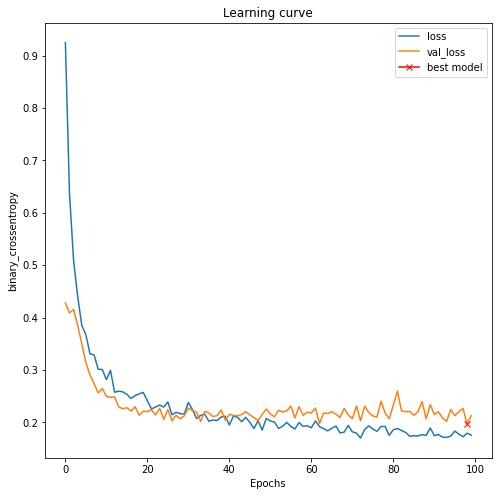

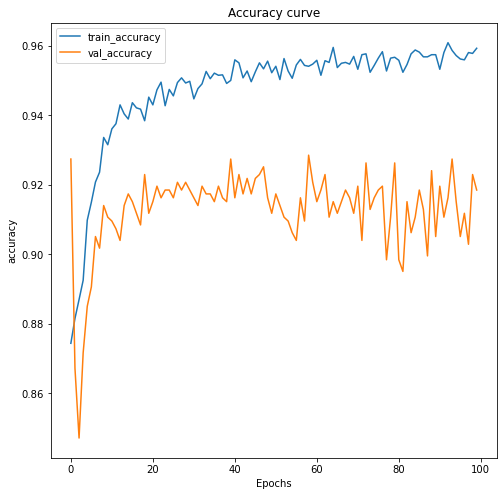

In [11]:
# plot loss
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("binary_crossentropy")
plt.savefig("./arbitrator_loss")
plt.legend();
#plot accuracy
plt.figure(figsize=(8, 8))
plt.title("Accuracy curve")
plt.plot(results.history["accuracy"], label="train_accuracy")
plt.plot(results.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.savefig("./arbitrator_acc")
plt.legend();